In [55]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow as tf
from pix2vid2 import make_model
from utils import check_tf_gpu, describe_data, load_data

msteps = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
NUM_REALIZATIONS = 1000
NX,  NY,  NZ = 64, 64, 1
NTT, NT1, NT2 = 40, 20, len(msteps)
HIDDEN = [16, 64, 256]

RES_WATER = 0.10
RES_CO2   = 0.20

folder     = 'SlopingAquiferSmall/simulationsVE'
sec2year   = 365.25 * 24 * 60 * 60
Darcy      = 9.869233e-13
psi2pascal = 6894.76
co2_rho    = 686.5266
milli      = 1e-3
mega       = 1e6
check_tf_gpu()

--------------------------------------------------------------
------------------------ VERSION INFO ------------------------
TF version: 2.15.0 | Keras: 3.5.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
--------------------------------------------------------------



In [56]:
gt = sio.loadmat('{}/grids/Gt.mat'.format(folder), simplify_cells=True)['Gt']
gtops = gt['cells']['z'].reshape(NX,NY,order='F')
gvols = gt['parent']['cells']['volumes'].reshape(NX,NY,order='F')
ghght = gt['cells']['H'].reshape(NX,NY,order='F')

deltatime = sio.loadmat('{}/data/time_arr.mat'.format(folder), simplify_cells=True)['time_arr']
timesteps = np.cumsum(deltatime)
timesteps_inj = timesteps[:20]
timesteps_mon = timesteps[20:][msteps]
#timesteps_mon = timesteps[[19, 24, 29, 34, 39]]

print('timesteps: {} | deltatime: {}'.format(len(timesteps), np.unique(deltatime)))
print('injection: {}'.format(timesteps_inj))
print('monitoring: {}'.format(timesteps_mon))

timesteps: 40 | deltatime: [  0.5 100. ]
injection: [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
monitoring: [ 110.  310.  510.  710.  910. 1110. 1310. 1510. 1710. 1910.]


In [57]:
datas, norms = load_data(folder)
X_data, c_data, y1_data, y2_data = datas.values()

X: (1000, 64, 64, 5) | c: (1000, 20, 5)
y1: (1000, 20, 64, 64, 2) | y2: (1000, 20, 64, 64, 1)
porosity     - min: -0.62 | max: 2.36
logperm      - min: -2.20 | max: 2.49
wells        - min: 0.00 | max: 1.00
tops         - min: 0.00 | max: 1.00
volumes      - min: 0.00 | max: 1.00
controls     - min: 0.00 | max: 0.97
pressure_1   - min: 0.00 | max: 15.39
saturation_1 - min: 0.00 | max: 1.00
saturation_2 - min: 0.00 | max: 1.00


In [89]:
train_idx = np.load('{}/models/training_idx.npy'.format(folder))
test_idx  = np.setdiff1d(range(len(X_data)), train_idx)

tridx = train_idx[:50]
teidx = test_idx[:50]

X_train  = tf.cast(X_data[tridx], tf.float32)
c_train  = tf.cast(c_data[tridx], tf.float32)
y1_train = tf.cast(y1_data[tridx], tf.float32)
y2_train = tf.cast(y2_data[tridx], tf.float32)

X_test  = tf.cast(X_data[teidx], tf.float32)
c_test  = tf.cast(c_data[teidx], tf.float32)
y1_test = tf.cast(y1_data[teidx], tf.float32)
y2_test = tf.cast(y2_data[teidx], tf.float32)

In [90]:
model_inj, model_mon = make_model(hidden=HIDDEN, nt1=NT1, nt2=NT2)

model_inj.load_weights('{}/models/pix2vid-v2-inj.weights.h5'.format(folder))
model_mon.load_weights('{}/models/pix2vid-v2-mon.weights.h5'.format(folder))

y1_train_pred = model_inj.predict([X_train, c_train], verbose=False)
y2_train_pred = model_mon.predict([X_train, c_train], verbose=False)

y1_test_pred = model_inj.predict([X_test, c_test], verbose=False)
y2_test_pred = model_mon.predict([X_test, c_test], verbose=False)

y1_train_pred = np.array(y1_train_pred)
y2_train_pred = np.array(y2_train_pred)
y1_test_pred = np.array(y1_test_pred)
y2_test_pred = np.array(y2_test_pred)

X_train = np.array(X_train)
c_train = np.array(c_train)
y1_train = np.array(y1_train)
y2_train = np.array(y2_train)

X_test = np.array(X_test)
c_test = np.array(c_test)
y1_test = np.array(y1_test)
y2_test = np.array(y2_test)

print('Train - y1: {} | y2: {}'.format(y1_train_pred.shape, y2_train_pred.shape))
print('Test - y1: {} | y2: {}'.format(y1_test_pred.shape, y2_test_pred.shape))

# parameters: 87,162,769 | 43,687,525


I0000 00:00:1724927568.836681 1012101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Train - y1: (50, 20, 64, 64, 2) | y2: (50, 10, 64, 64, 1)
Test - y1: (50, 20, 64, 64, 2) | y2: (50, 10, 64, 64, 1)


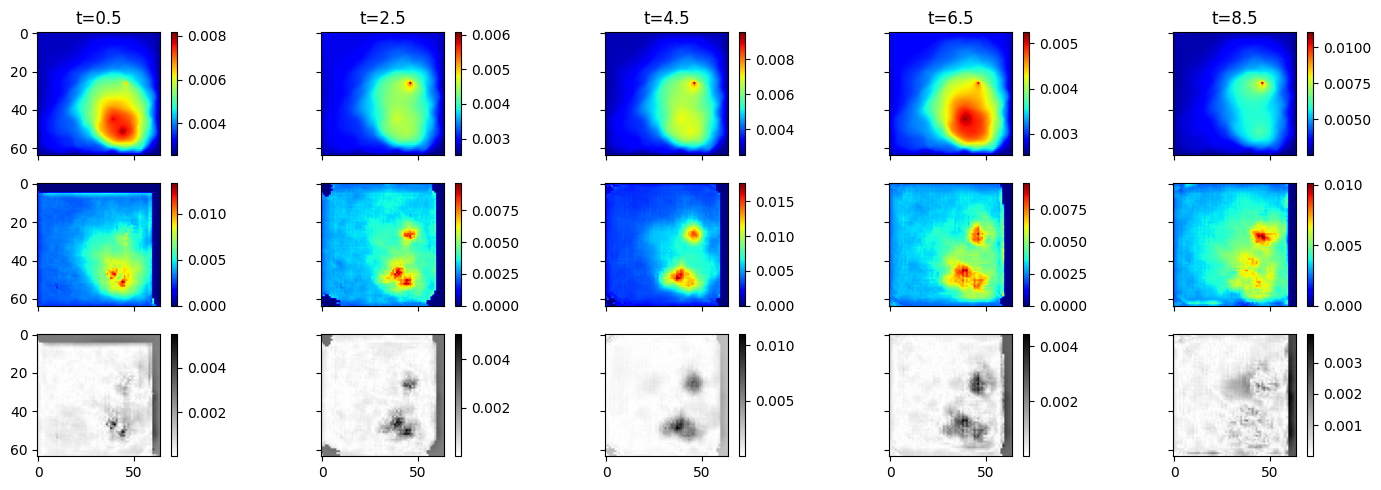

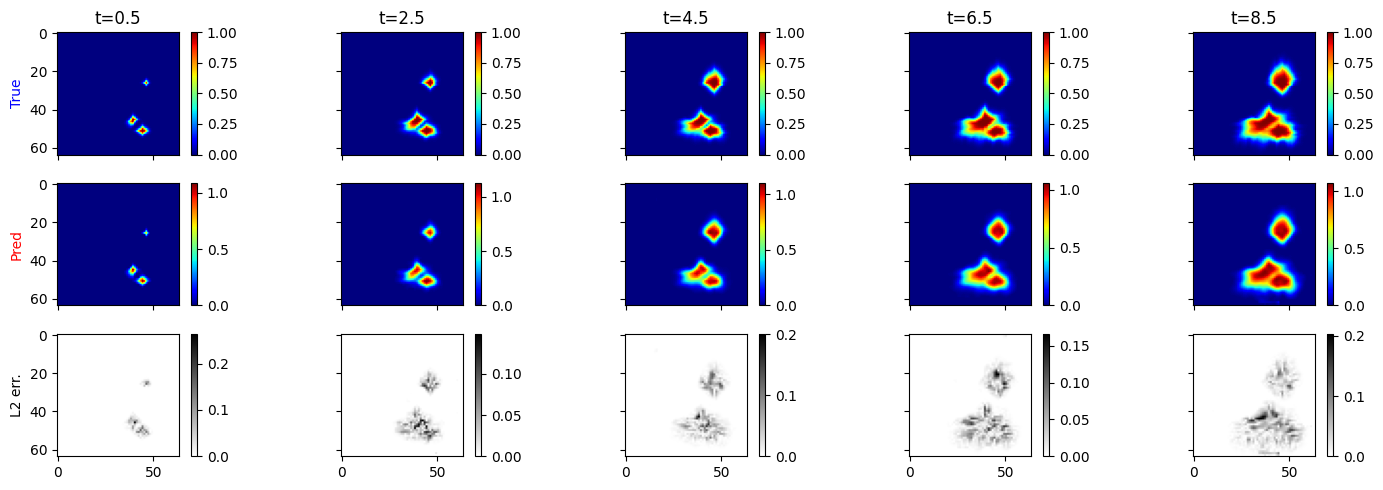

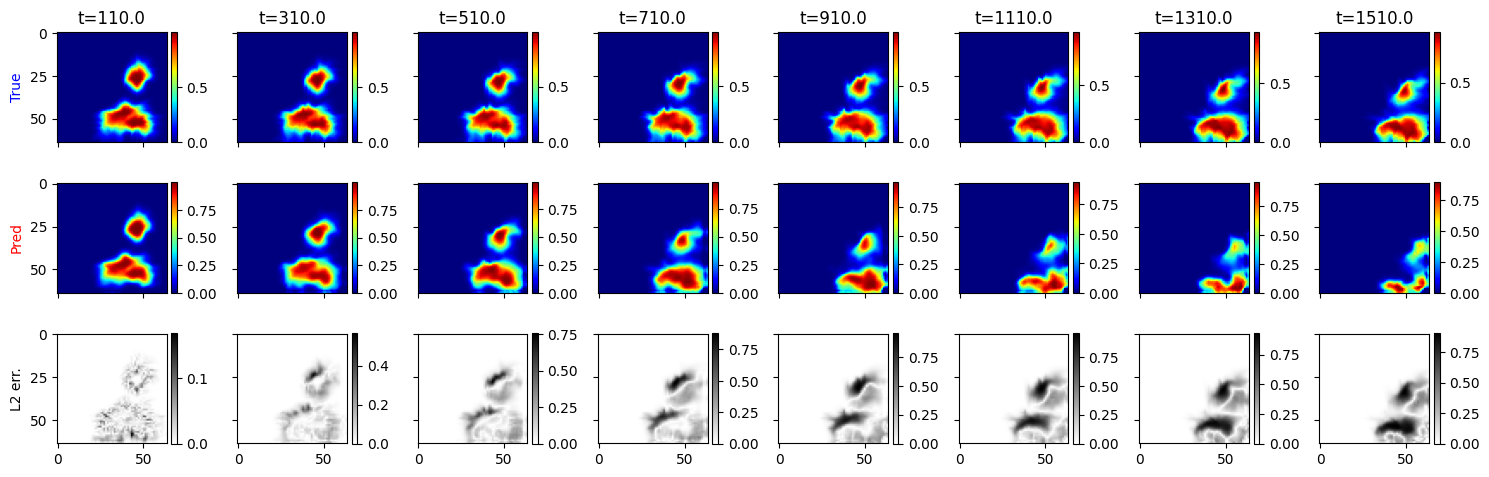

In [107]:
sample = 43

fig, axs = plt.subplots(3, 5, figsize=(15,5), sharex=True, sharey=True)
for j in range(5):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    k = j*4
    
    t = y1_train[sample, k, ..., 0]
    p = y1_train_pred[sample, k, ..., 0]
    e = np.linalg.norm(t.reshape(1,64,64)-p.reshape(1,64,64), axis=0)

    im1 = ax1.imshow(t, cmap='jet')
    im2 = ax2.imshow(p, cmap='jet')
    im3 = ax3.imshow(e, cmap='binary')
    [plt.colorbar(ii, pad=0.04, fraction=0.046) for ii in [im1,im2,im3]]
    ax1.set_title('t={}'.format(timesteps[k]))
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 5, figsize=(15,5), sharex=True, sharey=True)
for j in range(5):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    k = j*4
    
    t = y1_train[sample, k, ..., 1]
    p = y1_train_pred[sample, k, ..., 1]
    e = np.linalg.norm(t.reshape(1,64,64)-p.reshape(1,64,64), axis=0)

    im1 = ax1.imshow(t, cmap='jet')
    im2 = ax2.imshow(p, cmap='jet')
    im3 = ax3.imshow(e, cmap='binary')
    ax1.set_ylabel('True', color='b') if j==0 else None
    ax2.set_ylabel('Pred', color='r') if j==0 else None
    ax3.set_ylabel('L2 err.', color='k') if j==0 else None
    [plt.colorbar(ii, pad=0.04, fraction=0.046) for ii in [im1,im2,im3]]
    ax1.set_title('t={}'.format(timesteps[k]))
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 8, figsize=(15,5), sharex=True, sharey=True)
for j in range(8):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]

    t = y2_train[sample, j, ..., -1]
    p = y2_train_pred[sample, j, ..., -1]
    e = np.linalg.norm(t.reshape(1,64,64)-p.reshape(1,64,64), axis=0)

    im1 = ax1.imshow(t, cmap='jet')
    im2 = ax2.imshow(p, cmap='jet')
    im3 = ax3.imshow(e, cmap='binary')
    ax1.set_ylabel('True', color='b') if j==0 else None
    ax2.set_ylabel('Pred', color='r') if j==0 else None
    ax3.set_ylabel('L2 err.', color='k') if j==0 else None
    [plt.colorbar(ii, pad=0.04, fraction=0.046) for ii in [im1,im2,im3]]
    ax1.set_title('t={}'.format(timesteps_mon[j]))

plt.tight_layout()
plt.show()

In [ ]:
hues = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(15,7.5))
for i in range(15):
    plt.subplot(3, 5, i+1)
    d = c_data[i]
    nw = len(np.unique(d.sum(0)))-1
    for w in range(nw):
        for t in range(len(timesteps_inj)-1):
            plt.hlines(d[t,w], timesteps_inj[t], timesteps_inj[t+1], color=hues[w])
            plt.vlines(timesteps_inj[t+1], d[t,w], d[t+1,w], color=hues[w], ls=':', lw=0.5)
    plt.title('R{} | ({})'.format(i, nw))
    plt.xlim(0.5,10)
    plt.ylim(0,None)
    plt.xticks(np.arange(1,11))
    plt.grid(True, which='both', alpha=0.25)
    plt.xlabel('Time (years)') if i > 9 else None
    plt.ylabel('Inj. Rate (MT CO2)') if i % 5 == 0 else None
plt.tight_layout()
plt.show()

***
### Optimization

In [5]:
import keras
import tensorflow as tf
from keras import Model, layers, losses, optimizers

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [6]:
pmin, pmax = X_data[...,0].min(), X_data[...,0].max()
kmin, kmax = X_data[...,1].min(), X_data[...,1].max()
p = (X_data[...,0] - pmin) / (pmax - pmin)
k = (X_data[...,1] - kmin) / (kmax - kmin)
R_data = np.stack([p,k], -1)
print(R_data.shape)

ww = np.zeros((NUM_REALIZATIONS,5,2))
nwlist = []
for i in range(NUM_REALIZATIONS):
    w = np.argwhere(X_data[i,...,2]) / 55
    nw = len(w)
    nwlist.append(nw)
    ww[i,:nw] = w
ww = np.moveaxis(ww, -1, 1)

ww_train = tf.cast(ww[train_idx], tf.float32)
cc_train = tf.cast(c_data[train_idx], tf.float32)
rr_train = tf.cast(np.expand_dims(X_data[train_idx,...,0],-1), tf.float32)
print('Train - wells: {} | controls: {} | rock: {}'.format(ww_train.shape, cc_train.shape, rr_train.shape))

ww_test = tf.cast(ww[test_idx], tf.float32)
cc_test = tf.cast(c_data[test_idx], tf.float32)
rr_test = tf.cast(np.expand_dims(X_data[test_idx,...,0],-1), tf.float32)
print('Test  - wells: {} | controls: {} | rock: {}'.format(ww_test.shape, cc_test.shape, rr_test.shape))

########## freeVol, trappedVol, leakedVol, totVol ##########
volumes = np.load('{}/data/volumes.npy'.format(folder))
print('Volumes: {}'.format(volumes.shape))

leakedVols = volumes[:,-1,2] / 35
leaked_train = tf.cast(leakedVols[train_idx], tf.float32)
leaked_test  = tf.cast(leakedVols[test_idx], tf.float32)
print('Leaked Volumes - train: {} | test: {}'.format(leaked_train.shape, leaked_test.shape))

allVols = volumes[:,-1,:-1] / 35
allVols_train = tf.cast(allVols[train_idx], tf.float32)
allVols_test  = tf.cast(allVols[test_idx], tf.float32)
print('All Volumes    - train: {} | test: {}'.format(allVols_train.shape, allVols_test.shape))

(1000, 64, 64, 2)
Train - wells: (600, 2, 5) | controls: (600, 20, 5) | rock: (600, 64, 64, 1)
Test  - wells: (400, 2, 5) | controls: (400, 20, 5) | rock: (400, 64, 64, 1)
Volumes: (1000, 40, 4)
Leaked Volumes - train: (600,) | test: (400,)
All Volumes    - train: (600, 3) | test: (400, 3)


In [ ]:
def make_leakage_model(verbose:bool=True, drop=0.1):
    w_inp = layers.Input(shape=(2,5))
    c_inp = layers.Input(shape=(20,5))
    r_inp = layers.Input(shape=(64,64,1))

    def conv_bn_relu(x, filters):
        x = layers.SeparableConv2D(filters, kernel_size=3, padding='same')(x)
        x = layers.GroupNormalization(groups=-1)(x)
        x = layers.PReLU()(x)
        x = layers.MaxPooling2D()(x)
        return x
    
    def linear_bn_relu(x, units):
        x = layers.Dense(units, kernel_initializer='uniform')(x)
        x = layers.BatchNormalization()(x)
        x = layers.PReLU()(x)
        x = layers.Dropout(drop)(x)
        return x
    
    r = conv_bn_relu(r_inp, 16)
    r = conv_bn_relu(r, 64)
    r = conv_bn_relu(r, 256)

    r = layers.Flatten()(r)
    r = linear_bn_relu(r, 1024)
    r = linear_bn_relu(r, 1024)

    w = linear_bn_relu(w_inp, 128)
    w = linear_bn_relu(w, 128)
    w = layers.Flatten()(w)

    c = layers.LSTM(256, return_sequences=False, dropout=drop)(c_inp)
    c = linear_bn_relu(c, 256)

    wc = layers.Multiply()([w,c])
    wc = linear_bn_relu(wc, 1024)
    wc = linear_bn_relu(wc, 1024)

    wcr = layers.Multiply()([wc, r])
    x = linear_bn_relu(wcr, 1024)
    x = linear_bn_relu(x, 1024)

    output = layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=[w_inp, c_inp, r_inp], outputs=output)
    print('# parameters: {:,}'.format(model.count_params())) if verbose==True else None

    return model

model_leak = make_leakage_model()
#model_leak.summary()
optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-6)
criterion = losses.KLDivergence()
model_leak.compile(optimizer=optimizer, loss=criterion, metrics=['mse'])
start = time()
fit = model_leak.fit([ww_train, cc_train, rr_train], allVols_train,
                     epochs = 100,
                     batch_size = 40,
                     validation_split = 0.10,
                     shuffle = True,
                     verbose = False)
print('Training time: {:.3f} minutes'.format((time()-start)/60))
model_leak.save('SlopingAquiferSmall/SimulationsVE/models/leakage_model.keras')
pd.DataFrame(fit.history).to_csv('SlopingAquiferSmall/SimulationsVE/models/leakage_model_history.csv')

plt.figure(figsize=(6,4))
plt.plot(fit.history['loss'], label='loss')
plt.plot(fit.history['val_loss'], label='val_loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, which='both', alpha=0.5)
plt.tight_layout(); plt.show()

In [7]:
model_leak = keras.models.load_model('{}/models/leakage_model.keras'.format(folder))
print('# params: {:,}'.format(model_leak.count_params()))

# params: 21,843,548


Train - true: (600, 3) | pred: (600, 3)
Test  - true: (400, 3) | pred: (400, 3)
--------------------------------------------------
Train
-----
Free - R2: 0.868 | MSE: 0.005 | MAPE: 0.076
Trapped - R2: 0.831 | MSE: 0.001 | MAPE: 0.156
Leaked - R2: 0.878 | MSE: 0.003 | MAPE: 0.709
Test
-----
Free - R2: 0.004 | MSE: 0.039 | MAPE: 0.929
Trapped - R2: 0.176 | MSE: 0.004 | MAPE: 0.469
Leaked - R2: 0.013 | MSE: 0.028 | MAPE: 9.636


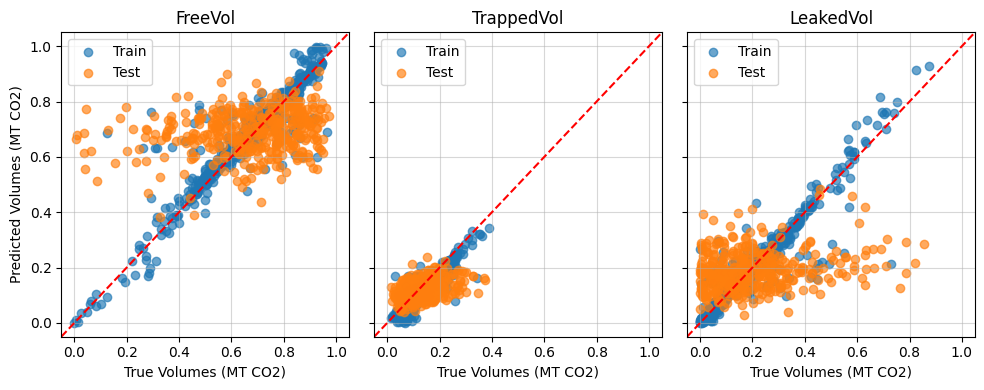

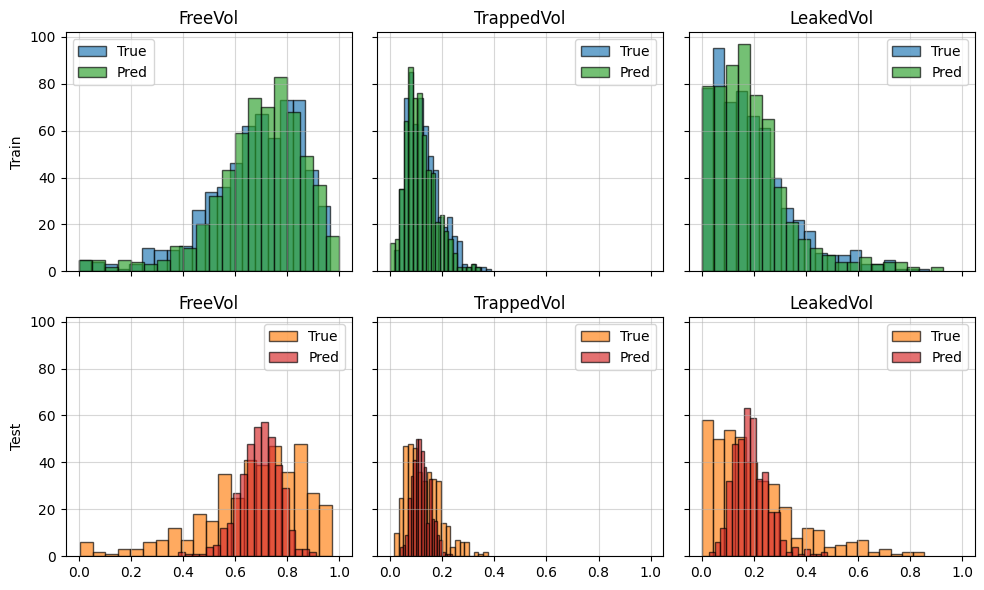

In [8]:
allVols_train_pred = model_leak.predict([ww_train, cc_train, rr_train], verbose=False)
allVols_test_pred = model_leak.predict([ww_test, cc_test, rr_test], verbose=False)

allVols_train, allVols_test = np.array(allVols_train), np.array(allVols_test)
allVols_train_pred, allVols_test_pred = np.array(allVols_train_pred), np.array(allVols_test_pred)

print('Train - true: {} | pred: {}'.format(allVols_train.shape, allVols_train_pred.shape))
print('Test  - true: {} | pred: {}'.format(allVols_test.shape,  allVols_test_pred.shape))
print('-'*50)

#################### Error Metrics ####################
def calc_metrics(true, pred, labels=['Free','Trapped','Leaked'], header:str=None):
    print(header+'\n'+'-'*5) if header is not None else None
    for i in range(3):
        r2 = r2_score(true[:,i], pred[:,i])
        mse = mean_squared_error(true[:,i], pred[:,i])
        mape = mean_absolute_percentage_error(true[:,i], pred[:,i])
        print('{} - R2: {:.3f} | MSE: {:.3f} | MAPE: {:.3f}'.format(labels[i], r2,mse,mape))
    return None

calc_metrics(allVols_train, allVols_train_pred, header='Train')
calc_metrics(allVols_test, allVols_test_pred, header='Test')

#################### True vs Pred ####################
fig, axs = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True)
labels = ['FreeVol','TrappedVol','LeakedVol']
for i in range(3):
    ax = axs[i]
    ax.scatter(allVols_train[:,i], allVols_train_pred[:,i], c='C0', alpha=0.66, label='Train')
    ax.scatter(allVols_test[:,i],  allVols_test_pred[:,i],  c='C1', alpha=0.66, label='Test')
    ax.grid(True, which='both', alpha=0.5); ax.legend()
    ax.set(xlabel='True Volumes (MT CO2)', ylabel='Predicted Volumes (MT CO2)' if i==0 else None, 
           title=labels[i], xlim=(-0.05,1.05), ylim=(-0.05,1.05))
    ax.axline([0,0],[1,1], color='r', ls='--')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(10,6), sharex=True, sharey=True)
for i in range(2):
    for j in range(3):
        ax = axs[i,j]
        ax.hist([allVols_train, allVols_test][i][:,j], bins=20, edgecolor='k', alpha=0.66, color=['C0','C1'][i], label='True')
        ax.hist([allVols_train_pred, allVols_test_pred][i][:,j], bins=20, edgecolor='k', alpha=0.66, color=['C2','C3'][i], label='Pred')
        ax.set(title=labels[j], ylabel=['Train','Test'][i] if j==0 else None)
        ax.grid(True, which='both', alpha=0.5); ax.legend()
plt.tight_layout()
plt.show()

***
### Optimization

In [285]:
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.core.mixed import MixedVariableGA

from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.core.variable import Real, Integer, Choice, Binary

In [286]:
print('W: {} | C: {} | R: {}'.format(ww_train.shape, cc_train.shape, rr_train.shape))
print('W - min: {:.2f} | max: {:.2f}'.format(np.array(ww_train).min(), np.array(ww_train).max()))
print('C - min: {:.2f} | max: {:.2f}'.format(np.array(cc_train).min(), np.array(cc_train).max()))
print('R - min: {:.2f} | max: {:.2f}'.format(np.array(rr_train).min(), np.array(rr_train).max()))

model_leak = keras.models.load_model('{}/models/leakage_model.keras'.format(folder))
print('# params: {:,}'.format(model_leak.count_params()))

W: (600, 2, 5) | C: (600, 20, 5) | R: (600, 64, 64, 1)
W - min: 0.00 | max: 1.00
C - min: 0.00 | max: 0.97
R - min: -0.62 | max: 2.36
# params: 21,843,548


In [288]:
class PlacementOpt(Problem):
    def __init__(self, *args, **kwargs):
        super().__init__(n_var=8, n_obj=1, xl=8, xu=55)
        self.r = args[0]
        self.c = args[1]
    
    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(-1, 2, 4) / 55
        w = tf.cast(np.concatenate([x, np.zeros((x.shape[0],2,1))], -1), tf.float32)
        c = tf.cast(np.repeat(np.expand_dims(self.c, 0), x.shape[0], 0), tf.float32)
        r = tf.cast(np.repeat(np.expand_dims(self.r, 0), x.shape[0], 0), tf.float32)
        y = model_leak.predict([w,c,r], verbose=False).squeeze()
        out['F'] = y[:,-1]

class ControlOpt(Problem):
    def __init__(self, *args, **kwargs):
        super().__init__(n_var=80, n_obj=1, n_ieq_constr=0, n_eq_constr=1, xl=0, xu=1)
        self.r = args[0]
        self.w = args[1]

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(-1, 20, 4)
        c = tf.cast(np.concatenate([x, np.zeros((x.shape[0],20,1))], -1), tf.float32)
        w = tf.cast(np.repeat(np.expand_dims(self.w, 0), x.shape[0], 0), tf.float32)
        r = tf.cast(np.repeat(np.expand_dims(self.r, 0), x.shape[0], 0), tf.float32)
        y = model_leak.predict([w,c,r], verbose=False)
        out['F'] = y[:,-1]
        out['H'] = np.sum(x, (-2,-1)) - 7.0

optW = []
optC = []
optLc = []
optLw = []
c0 = np.concatenate([np.ones(shape=(20,4)), np.zeros(shape=(20,1))], axis=-1) / 20 * (7/4)
for i in range(5):
    rock = rr_train[i]
    opt_wlocs = minimize(PlacementOpt(rock, c0), PSO(adaptive=True, pop_size=100, repair=RoundingRepair(), sampling=IntegerRandomSampling()), verbose=0)
    w = np.concatenate([opt_wlocs.X.reshape(2,4), np.zeros((2,1))], -1)
    opt_ctrls = minimize(ControlOpt(rock, w), GA(pop_size=10), verbose=0)
    optW.append(opt_wlocs.X.reshape(2,4))
    optC.append(opt_ctrls.X)
    optLw.append(opt_wlocs.F)
    optLc.append(opt_ctrls.F)

In [215]:
optimalW, optimalC = np.load('optW.npy'), np.load('optC.npy')
print(optimalW.shape, optimalC.shape)

(50, 2, 4) (50, 20, 4)


'lanczos', 'bessel', 'sinc', 'spline36', 'bilinear', 'nearest', 'none', 'blackman', 'kaiser', 'hermite', 'antialiased', 'hanning', 'quadric', 'gaussian', 'spline16', 'mitchell', 'bicubic', 'hamming', 'catrom'

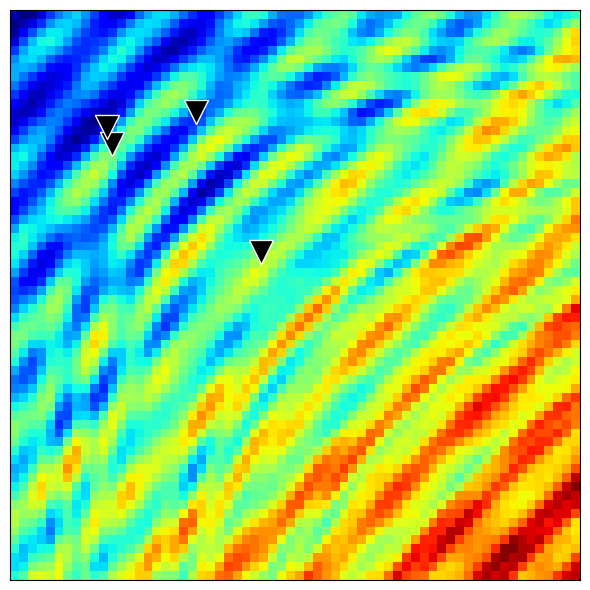

In [307]:
plt.figure(figsize=(8,6))
plt.imshow(ghght, cmap='jet_r')
plt.scatter(optimalW.mean(0)[0,:], optimalW.mean(0)[1,:], marker='v', color='k', edgecolor='w', s=300)
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

(20, 4)


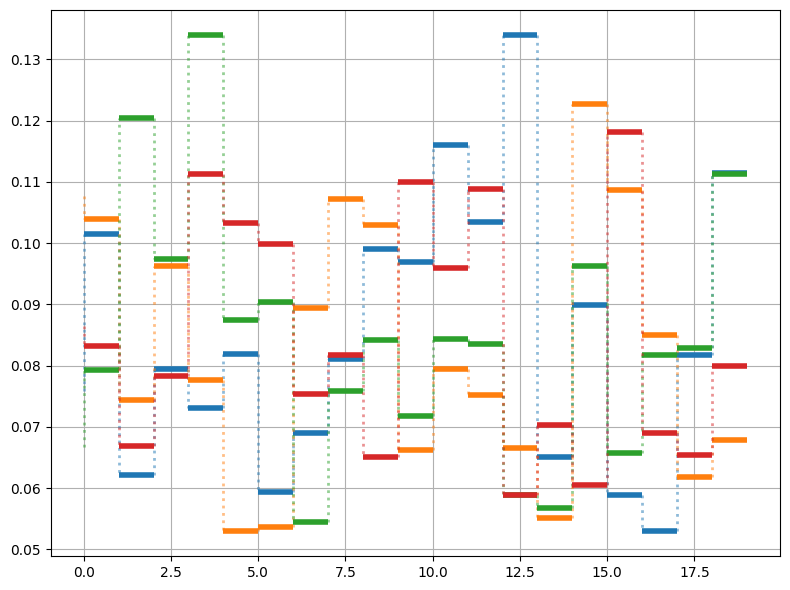

In [293]:
temp = optimalC.mean(0)
print(temp.shape)

plt.figure(figsize=(8,6))
for i in range(4):
    for t in range(1,20):
        plt.hlines(temp[t,i], t-1, t, color='C{}'.format(i), lw=4)
        plt.vlines(t-1, temp[t-1,i], temp[t,i], ls=':', alpha=0.5, lw=2, color='C{}'.format(i))
plt.grid(True, which='both')
#plt.ylim(0,0.25)
plt.tight_layout()
plt.show()

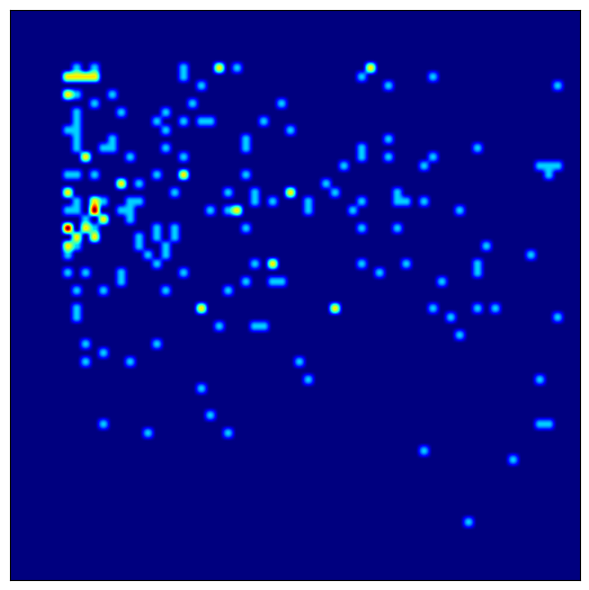

In [257]:
heatmap_grid = np.zeros((64,64))

for i in range(50):
    for j in range(4):
        x, y = optimalW[i,:,j]
        heatmap_grid[y+6, x+6] += 1

plt.figure(figsize=(10,6))

plt.imshow(heatmap_grid, interpolation='hanning', cmap='jet')
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

***
# END